In [160]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math
import emcee
import corner
import random
from IPython.display import display, Math
import getdist
from getdist import plots, MCSamples
from astropy import units as u
from gammapy.modeling.models import ExpCutoffPowerLawSpectralModel, Models, SkyModel, EBLAbsorptionNormSpectralModel, LogParabolaSpectralModel
from ebltable.tau_from_model import OptDepth
from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors
%matplotlib inline

In [2]:
"""Unit System & Warnings"""

# observed unit in TeV, cm, s, Gauss
# for ma and g: 
#       ma(presented) = ma(computed) * 10**(-6) eV  (i.e. in mueV)
#       g(presented) = g(computed) * 10**(-11) GeV-1

# Optdepth package can only read data up to 100 TeV, causing the spike in graph

'Unit System & Warnings'

In [159]:
# fundamental constant
# earth magnetic field 0.5*10**(-6) Gauss fitted by paper
# scale 4 kpc according to paper

c = 3 * 10**8     # speed of light
hbar = 1.054 * 10**(-34)    # Planck constant
epsilon = 8.854 * 10**(-12)   # electric permittivity
converter = (1*u.Unit('GeV-1 Gauss')).to(u.Unit('Joule-1 Tesla')).value     # convert g*B to SI unit
length = (1*u.kiloparsec).to(u.m).value     # from kpc to m

BE = (0.5*10**(-6) * u.Gauss).value  # earth magnetic field
rE = (4 * u.kiloparsec).value  # earth magnetic field scale

In [4]:
# conversion probability by original paper
def psga(g, ma, B, r, E):
    # probability of photon-APL conversion at a place with B field and scale r, of energy E
    return (1/2) * (g *10**(-11) * B / osc(g, ma, B, E))**2 * (math.sin(osc(g, ma, B, E) * converter * r * length * c**(3/2) * hbar**(1/2) * epsilon**(1/2) / 2))**2

def psgg(g, ma, B, r, E):
    # probability of not converting
    return 1 - psga(g, ma, B, r, E)


def pgga(g, ma, E):
    # probability of photong converting to APL on Earth
    return psga(g, ma, BE, rE, E)

def pgag(g, ma, E):
    # probability of converting back to photon on Earth
    return 2 * pgga(g, ma, E)

def pggg(g, ma, E):
    # probability of not converting APL on Earth
    return 1 - pgga(g, ma, E)


def osc(g, ma, B, E):
    # oscillation term
    return g * 10**(-11) * B * (1 + (Ecrit(g, ma, B)/E + E/EH(g, B))**2)**(1/2)

def Ecrit(g, ma, B):
    # critical energy for conversion, in TeV unit
    return 38 * ma**2 * (10**(-5) / B) * (6.5/g)

def Ecritlist(glist, malist):
    # critical energy list for given g and ma, resutl logged
    result = []
    for i in range(len(glist)):
        result.append(Ecrit(glist[i], malist[i], 5e-6))
    return result

def EH(g, B):
    # photon one-loop polarization, in TeV unit
    return 2.1 * 10**(2) * (10**(-5) / B) * g

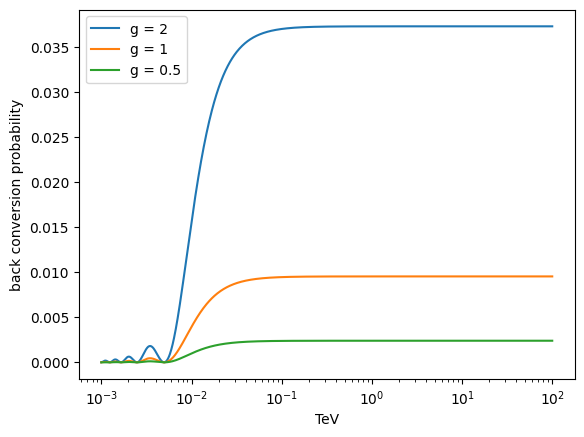

In [5]:
# conversion prob by another paper

def deltagamma(g, B):
    # in unit of kpc-1
    return 3.1 * 10**(-2) * (g/2) * (B/(10**(-6)))

def delta(ma, E):
    # in unit of kpc-1
    return -7.8 * 10**(-3) * (ma / (10**(-2)))**2 * (E)**(-1)

def deltpl(E):
    # in unit of kpc -1
    return -1.1 * 10**(-10) * E**(-1)

def deltosc(g, ma, B, E):
    # oscillation wave number, in kpc-1
    return ((deltpl(E) - delta(ma, E))**2 + 4 * deltagamma(g, B)**2)**(1/2)

def Pnot(g, ma, B, r, E):
    return (deltagamma(g, B) * r)**2 * math.sin(deltosc(g, ma, B, E) * r / 2)**2 / (deltosc(g, ma, B, E) * r / 2)**2

def Psga(g, ma, B, r, E):
    # probability of conversion at source, separate all galaxies' magnetic field into 10 regions
    return (1/3) * (1 - math.exp(-1.5 * 10 * Pnot(g, ma, B, r, E)))

def Psgg(g, ma, B, r, E):
    # probability of not converting at source
    return 1 - Psga(g, ma, B, r, E)

def Pggg(g, ma, E):
    # probability fo conversion at earth
    return Psga(g, ma, BE, rE, E)

def Pgag(g, ma, E):
    # probability of back converstion at Earth
    return 2*Psga(g, ma, BE, rE, E)

energies = np.logspace(-3, 2, 1000)
Bt = 10*10**(-6)
s = 3
pconv10 = []
pconv5 = []
pconv3 = []
pconv1 = []
for i in range(len(energies)):
    pconv10.append(Pgag(2, 0.01, energies[i]))
    pconv5.append(Pgag(1, 0.01, energies[i]))
    pconv3.append(Pgag(0.5, 0.01, energies[i]))
    #pconv1.append(Psga(2, 0.01, 10**(-6), s, energies[i]))
plt.plot(energies, pconv10, label = 'g = 2')
plt.plot(energies, pconv5, label='g = 1')
plt.plot(energies, pconv3, label = 'g = 0.5')
#plt.plot(energies, pconv1, label='B = 1 muG')
plt.xscale('log')
plt.xlabel('TeV')
plt.ylabel('back conversion probability')
plt.legend()

In [301]:
# basic spectrum function exponential cutoff

def PLC(phin, alpha, Ec, E0):
    # PLC model
    return ExpCutoffPowerLawSpectralModel(
    amplitude= phin * 10**(-9) * u.Unit('cm-2 s-1 TeV-1'),
    index=alpha,
    lambda_= (1/Ec) * u.Unit('TeV-1'),
    reference=E0 * u.TeV,
    )   

def ini_spectrum(phin, alpha, Ec, source, E0=1):
    # intrinsic spectrum generated
    Earray = source.Earray
    result = []
    #dnde = []
    dnde = PLC(phin, alpha, Ec, E0)(Earray * u.TeV).to_value()
    for i in range(len(Earray)):
        #dnde.append(phin * 10**(-12) * (Earray[i]/E0)**(-alpha) * math.exp(-Earray[i]/Ec))
        flux =  Earray[i]**2 * dnde[i]
        result.append(flux)
    return result

def prob(g, ma, B, r, E, source):
    # total probability of transmission
    return Psgg(g, ma, B, r, E) * source.EBL(E)\
    + Psga(g, ma, B, r, E) * Pgag(g, ma, E)

                        
def received_spectrum(phin, alpha, Ec, g, ma, source, E0=1):
    # modeling of spectrum received
    B = source.B
    r = source.r
    Earray = source.Earray
    ini = ini_spectrum(phin, alpha, Ec, source, E0)
    result = []
    for i in range(len(ini)):
        result.append(prob(g, ma, B, r, Earray[i], source) * ini[i])
    return result

def received_spectrum_wo(phin, alpha, Ec, source, E0=1):
    # modeling of spectrum received without APL
    Earray = source.Earray
    ini = ini_spectrum(phin, alpha, Ec, source, E0)
    result = []
    for i in range(len(ini)):
        result.append(source.EBL(Earray[i]) * ini[i])
    return result


In [313]:
# class for source

class Source():
    # packs information of a gamma ray source
    def __init__(self, name, Earray, fluxarray, dfluxarray, B, r, z, flat_samples):
        self.name = name
        self.Earray = Earray    # energies interval received
        self.fluxarray = fluxarray  # flux received
        self.dfluxarray = dfluxarray # standard deviation of flux
        self.B = B  # local magnetic field
        self.r = r  # local magnetic region scale
        self.z = z  # redshift
        self.tau = OptDepth.readmodel(model='finke2022') #EBLAbsorptionNormSpectralModel.read_builtin('Glimore', redshift=self.z)    # EBL model for source's redshift
        self.flat_samples = flat_samples    # markov chain from MCMC

    def EBL(self, E):
        return np.exp(-1 * self.tau.opt_depth(self.z, E))
    
    def plotenergy(self):
        # plotting the source's spectral energy distribution
        plt.scatter(self.Earray, self.fluxarray)
        plt.errorbar(self.Earray, self.fluxarray, self.dfluxarray, fmt='o', capsize=4)
        plt.xscale('log')
        plt.yscale('log')
        plt.title('SED of ' + self.name)
        plt.xlabel(r'$E_{\gamma}$' + ' ' + '(TeV)')
        plt.ylabel('flux' + ' ' + r'$E^{2} dN/dE$')
        plt.legend()

    def filter(self):
        def filter_array(array):
            result = []
            for i in range(len(array)):
                if not math.isnan(array[i]):
                    result.append(array[i])
            return result
        self.Earray = filter_array(self.Earray)
        self.fluxarray = filter_array(self.fluxarray)
        self.dfluxarray = filter_array(self.dfluxarray)

    def chi2_flat(self, par, fluxarray, dfluxarray, intrinsic_par=None):
        # using length of par to examine which parameters are to be constraint, assumed 2 for APL only, 3 for intrinsic spectrum only, 5 for all
        if len(par) == 2:
            # intrinsic par cannot be None if to constrain g and ma only
            g, ma = par
            phin, alpha, Ec = intrinsic_par
            spectrum = received_spectrum(phin, alpha, Ec, g, 0.01*ma, self)
        elif len(par) == 3:
            phin, alpha, Ec = par
            spectrum = received_spectrum_wo(phin, alpha, Ec, self)
            diff = 0
            for i in range(math.floor(0.6*len(spectrum))):
                # using only 60% of data to constrain intrinsic spectrum
                diff += ((fluxarray[i] - spectrum[i]) / dfluxarray[i])**2
            return diff    
        elif len(par) == 5:
            phin, alpha, Ec, g, ma = par
            spectrum = received_spectrum(phin, alpha, Ec, g, 0.01*ma, self)
        diff = 0
        for i in range(len(spectrum)):
            diff += ((fluxarray[i] - spectrum[i]) / dfluxarray[i])**2
        return diff
    
    def lnprior(self, par):
        if len(par) == 2:
            g, ma = par
            if 0 <= g <= 7 and 0 <= ma <= 50:
                return 0.0
            return -np.inf
        elif len(par) == 3:
            phin, alpha, Ec = par
            if 0 <= phin <= 40 and 0 <= alpha <= 100 and 0 <= Ec <= 100:
                return 0.0
            return -np.inf
        elif len(par)==5:
            phin, alpha, Ec, g, ma = par
            if 0 <= phin <= 40 and 0 <= alpha <= 100 and 0 <= Ec <= 100 and 0 <= g <= 20 and 0 <= ma <= 50:
                return 0.0
            return -np.inf
    
    def lnprob(self, par, fluxarray, dfluxarray, intrinsic_par=None):
        lp = self.lnprior(par)
        if not np.isfinite(lp):
            return -np.inf
        return lp - 0.5 * self.chi2_flat(par, fluxarray, dfluxarray, intrinsic_par)
    
    def plot_chain(self, ndim):
        # plotting parameter estimation result based on markov chain
        if ndim == 2:
            labels = [r'g_{\alpha\gamma}', r'm_{a}']
        elif ndim == 3:
            labels = [r'\phi_{0}', r'\alpha', r'E_{c}']
        elif ndim == 5:
            labels = [r'\phi_{0}', r'\alpha', r'E_{c}', r'g_{\alpha\gamma}', r'm_{a}']
        names = labels
        samples0 = MCSamples(samples=self.flat_samples, names=names, labels=labels)
        g = plots.get_subplot_plotter()
        g.triangle_plot(samples0, legend_labels=[self.name], title_limit=1, filled=True, colors=['blue'], line_args=[{'lw':1.5, 'color':'blue'}])
            
    def MCMC(self, ini_guess, intrinsic_par=None):
        ini = np.array(ini_guess)
        ndim, nwalkers = len(ini), 50
        ini = [ini + 1e-5 * np.random.randn(ndim) \
               for i in range(nwalkers)]
        sampler = emcee.EnsembleSampler(nwalkers, ndim, self.lnprob, \
                                        args=(self.fluxarray, self.dfluxarray, intrinsic_par))
        sampler.run_mcmc(ini, 500, progress=True)

        ax = [None] * ndim
        for i in range(ndim):
            ax[i] = plt.subplot2grid((ndim, 1), (i, 0))
            if i != ndim - 1:
                ax[i].set_xticklabels(())
        
        for i in range(nwalkers):
            for j in range(ndim):
                ax[j].plot(sampler.chain[i, :, j], 'k-', lw=0.5)
        plt.show()

        self.flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)  # preserve the chain, discarding the first 100 steps
        self.plot_chain(ndim)

In [141]:
# function for creating a source based on excel file

def generate_source(str, name, sheet_name=None, B=None, r=None, z=None, Ei=5, fi=6, dfi=7, clone=False, x=None):
    # enter file name, defaulty reading colum 5, 6, 7 for Energy, flux, dflux respectively
    # if requesting for a clone source, then return one immediately, usually inputing according field parameter
    if clone:
        return Source(name+'clone', x, None, None, B, r, z, None)
    else:
        if sheet_name is None:
            target = pd.read_excel(str)
        else:
            target = pd.read_excel(str, sheet_name=sheet_name)
        target_Earray = target.values[:,5].tolist()
        target_fluxarray = target.values[:,6].tolist()
        target_dfluxarray = target.values[:,7].tolist()
        output = Source(name, target_Earray, target_fluxarray, target_dfluxarray, B, r, z, None)
        output.filter()
        return output
    
def combine_source(sourcelist):
    # function for combining multiple sources from a list, generating a new source having the connected SED
    # usually used for multiple observation data points
    Earray, fluxarray, dfluxarray= [], [], []
    s = sourcelist[0]
    for source in sourcelist:
        Earray += source.Earray
        fluxarray += source.fluxarray
        dfluxarray += source.dfluxarray
    output = Source(s.name, Earray, fluxarray, dfluxarray, s.B, s.r, s.z, s.flat_samples)
    return output


In [8]:
# functions for graphing and searching

def probE(g, ma, source):
    # function calculate conversion probability of given energy
    B = source.B
    r = source.r
    def result(E):
        return prob(g, ma, B, r, E, source)
    return result

def probsource(g, ma, E):
    # conversion prob of given source
    def result(source):
        B = source.B
        r = source.r
        return prob(g, ma, B, r, E, source)
    return result

def probEsource(g, ma):
    # function conversion prob for given E and source
    def result(E, source):
        B = source.B
        r = source.r
        return prob(g, ma, B, r, E, source)
    return result

def probEsourcearray(g, ma):
    # function conversion prob for E and source array, result logged for presentation
    def result(Elist, sourcelist):
        output = []
        for i in range(len(Elist)):
            B = sourcelist[i].B
            r = sourcelist[i].r
            output.append(prob(g, ma, B, r, Elist[i], sourcelist[i]))
        return output
    return result

def EBLarray(Elist, sourcelist):
    output = []
    for i in range(len(Elist)):
        output.append(sourcelist[i].EBL(Elist[i]))
    return output

def EBLsource(E):
    # EBL result for a given source 
    def result(source):
        return source.EBL(E)
    return result


Text(0.5, 1.0, 'Critical Conversion Energy')

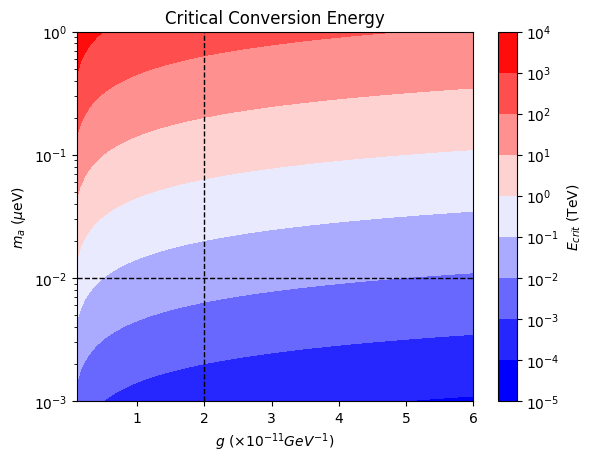

In [46]:
# plotting critical energy against g and ma

# setting g and ma list
glist = np.linspace(0.1, 6, 100)
malist = np.logspace(-3, 0, 100)
G, M = np.meshgrid(glist, malist)
Eclist = np.array(Ecritlist(np.ravel(G), np.ravel(M)))
Ec = Eclist.reshape(G.shape)

contour = plt.contourf(G, M, Ec, norm=colors.LogNorm(vmin=Ec.min(), vmax=Ec.max()), cmap='bwr')
plt.colorbar(contour, label=r'$E_{crit}$' + ' '+ '(TeV)')
plt.axvline(2, color='black', linestyle='--',linewidth=1)
plt.axhline(0.01, color='black', linestyle='--',linewidth=1)
plt.yscale('log')
plt.xlabel(r'$g$' + ' '+ r'($\times 10^{-11} GeV^{-1}$)')
plt.ylabel(r'$m_{a}$' + ' ' + r'$(\mu$eV)')
plt.title('Critical Conversion Energy')

Text(0.5, 1.0, 'Transmission Probability Ratio $g_{11}=2$')

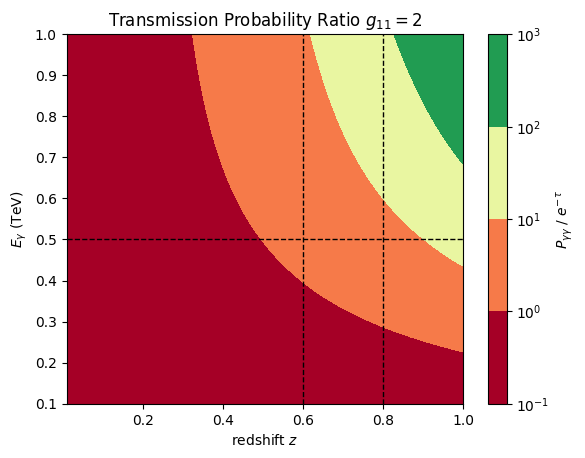

In [10]:
# 3D graphing for optimal redshift and energy interval

# setting up redshift and energy list and source list
zlist = np.linspace(0.01, 1, 100)
Elist = np.logspace(-1, 0, 100)
sourcelist = []
for i in range(len(zlist)):
    sourcelist.append(Source(None, None, None, None, 5*10**(-6), 3, zlist[i], None))

# meshgrid
Z, E= np.meshgrid(zlist, Elist)
S, EE = np.meshgrid(sourcelist, Elist)
ALPproblist = np.array(probEsourcearray(2, 0.01)(np.ravel(E), np.ravel(S)))
woALPproblist = np.array(EBLarray(np.ravel(E), np.ravel(S)))
A = ALPproblist.reshape(S.shape)
W = woALPproblist.reshape(S.shape)

contour = plt.contourf(Z, E, A/W, norm=colors.LogNorm(vmin=(A/W).min(), vmax=(A/W).max()), cmap='RdYlGn')
plt.colorbar(contour, label=r'$P_{\gamma\gamma}$' + ' ' + '/' + ' ' + r'$e^{-\tau}$')
plt.axhline(0.5, color='black', linestyle='--', linewidth=1)
plt.axvline(0.6, color='black', linestyle='--', linewidth=1)
plt.axvline(0.8, color='black', linestyle='--', linewidth=1)
plt.xlabel('redshift' + ' ' + r'$z$')
plt.ylabel(r'$E_{\gamma}$' + ' ' + '(TeV)')
plt.title('Transmission Probability Ratio ' + r'$g_{11}=2$')


In [11]:
zlist = np.linspace(0.01, 1, 100)
sourcelist = []
for z in zlist:
    sourcelist.append(Source(None, None, None, None, 5*10**(-6), 3, z, None))

Text(0.5, 1.0, 'Transmission Probability')

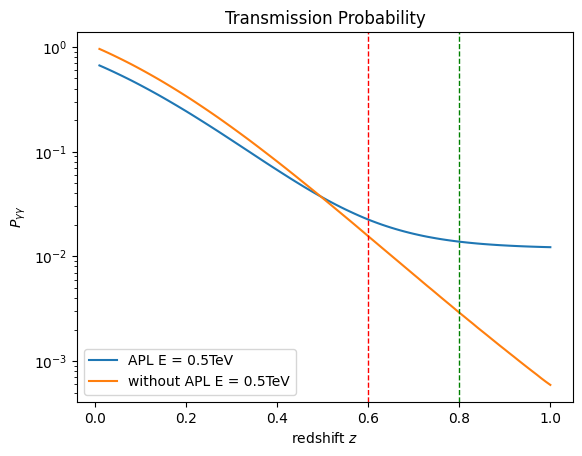

In [43]:
# 2D graphing for optimal redshift interval
Et1 = 0.5
plt.plot(zlist, list(map(probsource(2, 0.01, Et1), sourcelist)), label='APL E = 0.5TeV')
plt.plot(zlist, list(map(EBLsource(Et1), sourcelist)), label='without APL E = 0.5TeV')
plt.axvline(0.6, color='red', linestyle='--',linewidth=1)
plt.axvline(0.8, color='green', linestyle='--', linewidth=1)
plt.xlabel('redshift' + ' ' + r'$z$')
plt.ylabel(r'$P_{\gamma\gamma}$')
plt.yscale('log')
plt.legend()
plt.title('Transmission Probability')

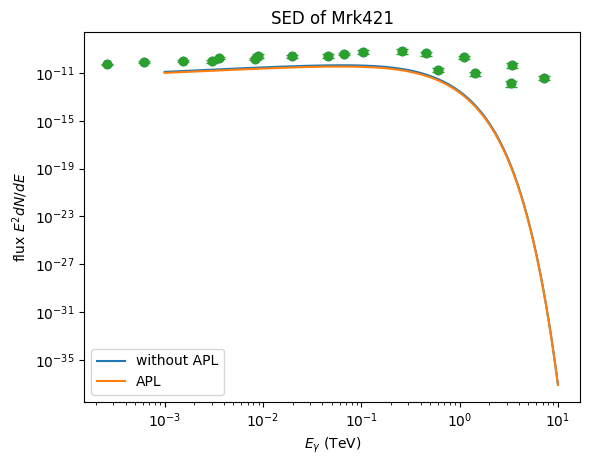

In [259]:
# reading file for Mrk 421
Mrk421_WCDA = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\Mrk 421\Mrk 421 WCDA flaring phase data.xlsx",
    name='Mrk421',
    sheet_name="Mrk 421 WCDA flaring phase data",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421_Fermi = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\Mrk 421\Mrk 421 WCDA flaring phase data.xlsx",
    name='Mrk421',
    sheet_name="Mrk 421 Fermi data",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421_ARGO = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\Mrk 421\Mrk 421 WCDA flaring phase data.xlsx",
    name='Mrk421',
    sheet_name="Mrk 421 ARGO data",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421 = combine_source([Mrk421_WCDA, Mrk421_Fermi, Mrk421_ARGO])
x = np.logspace(-3, 1, 1000)
Mrk421clone = generate_source(None, 'Mrk421clone', B=5e-6, r=3, z=0.031, clone=True, x=x)
plt.plot(x, received_spectrum_wo(200, 1.598, 0.159, Mrk421clone), label='without APL')
plt.plot(x, received_spectrum(200, 1.61, 0.159, 6, 0.0001, Mrk421clone), label='APL')
Mrk421.plotenergy()

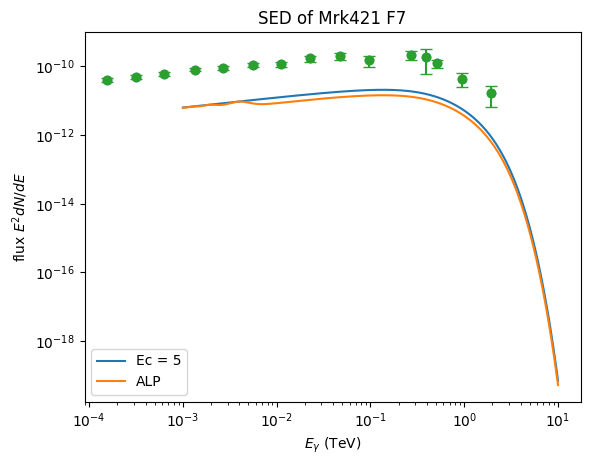

In [258]:
# reading file for Mrk 421 F7
Mrk421_F7ARGO = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\Mrk 421\Mrk 421 F7 data.xlsx",
    name='Mrk421 F7',
    sheet_name="Mrk 421 F7 ARGO",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421_F7Fermi = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\Mrk 421\Mrk 421 F7 data.xlsx",
    name='Mrk421 F7',
    sheet_name="Mrk 421 F7 Fermi",
    B=5e-6,
    r=3,
    z=0.031
)
Mrk421_F7 = combine_source([Mrk421_F7ARGO, Mrk421_F7Fermi])
x = np.logspace(-3, 1, 1000)
Mrk421_F7clone = generate_source(None, 'Mrk421 clone', B=5e-6, r=3, z=0.031, clone=True, x=x)
plt.plot(x, received_spectrum_wo(50, 1.7, 0.5, Mrk421_F7clone), label='Ec = 5')
plt.plot(x, received_spectrum(50, 1.7, 0.5, 3, 0.01, Mrk421_F7clone), label='ALP')
Mrk421_F7.plotenergy()

C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_11044\206854566.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


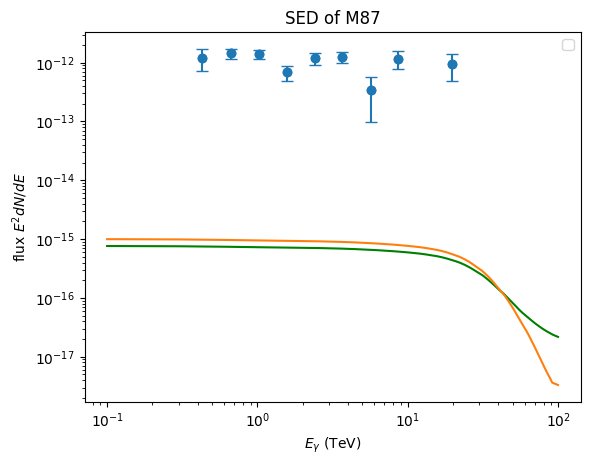

In [257]:
# reading the file for M87
M87 = generate_source(
    str = r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\M87\M87.xlsx",
    name = 'M87',
    B = 5e-6,
    r = 1,
    z = 0.00436
)
x = np.arange(0.1,100,0.1)
M87clone = generate_source(None, 'M87', B=5e-6, r=1, z=0.0046, clone=True, x=x)
M87.plotenergy()
plt.plot(x, received_spectrum(0.001, 2, 90, 5, 0.01, M87clone),color='green')
plt.plot(x, received_spectrum_wo(0.001, 2, 90, M87clone))

C:\Users\Yuchong Chen\AppData\Local\Temp\ipykernel_11044\1329224765.py:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


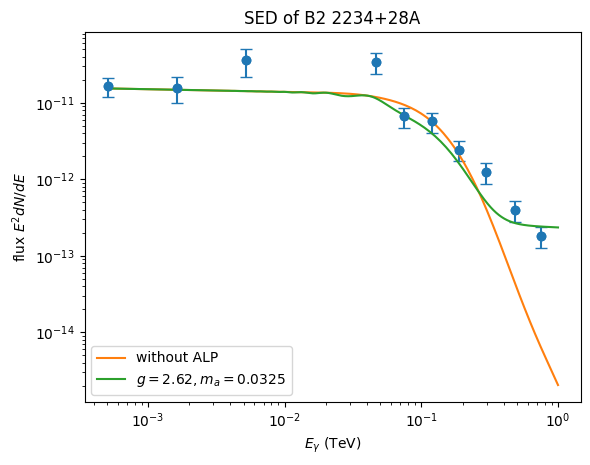

In [298]:
# reading file for B2 2234+28A
B2A = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\B2 2234+28A\B2 223428A data.xlsx",
    name='B2 2234+28A',
    B=5e-6, 
    r=3, 
    z=0.79
    )
x = np.logspace(-3.3, 0, 1000)
B2Aclone = generate_source(None, 'B2 2234+28A', B=5e-6, r=3, z=0.79, clone=True, x=x)
B2A.plotenergy()
plt.loglog(x, received_spectrum_wo(11.9, 2.034, 20, B2Aclone), label='without ALP')
plt.plot(x, received_spectrum(11.9, 2.034, 20, 2.62, 0.0325, B2Aclone), label=r'$g = 2.62, m_{a}=0.0325$')
plt.legend()

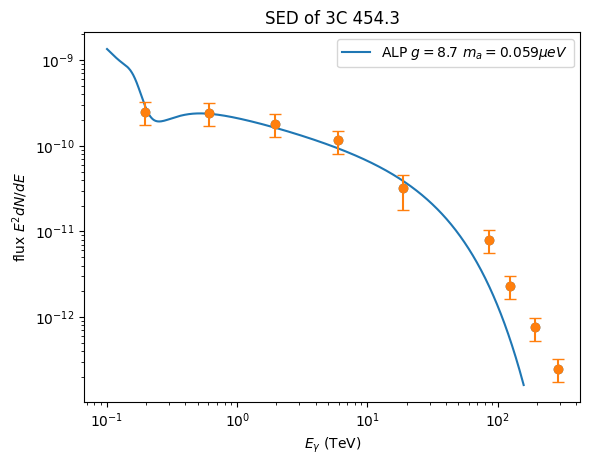

In [314]:
# reading file for 3C 454.3
C3454 = generate_source(
    str=r"C:\Users\Yuchong Chen\OneDrive\文档\科研\LHAASO AGN APL\数据处理\3C 4543\3C 4543.xlsx",
    name='3C 454.3', 
    B=5e-6, 
    r=3, 
    z=0.859
    )
x = np.logspace(-1, 2.2, 1000)
C3454clone = generate_source(None, '3C 454.3 clone', B=5e-6, r=3, z=0.859, clone=True, x=x)
plt.loglog(x, received_spectrum(1.55, 2.39, 30, 8.8, 0.057, C3454clone), label='ALP ' + r'$g=8.7$' + ' ' +r'$m_{a}=0.059 \mu eV$')
C3454.plotenergy()

100%|██████████| 500/500 [00:21<00:00, 23.38it/s]


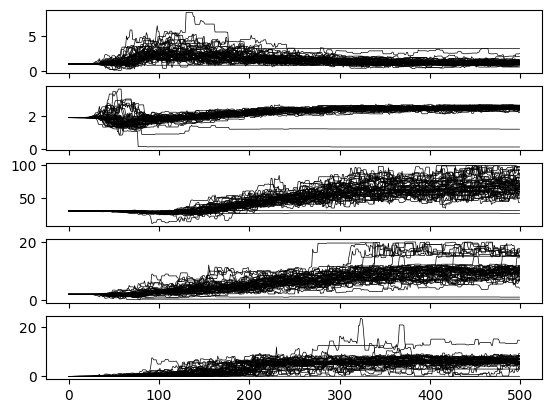

Removed no burn in


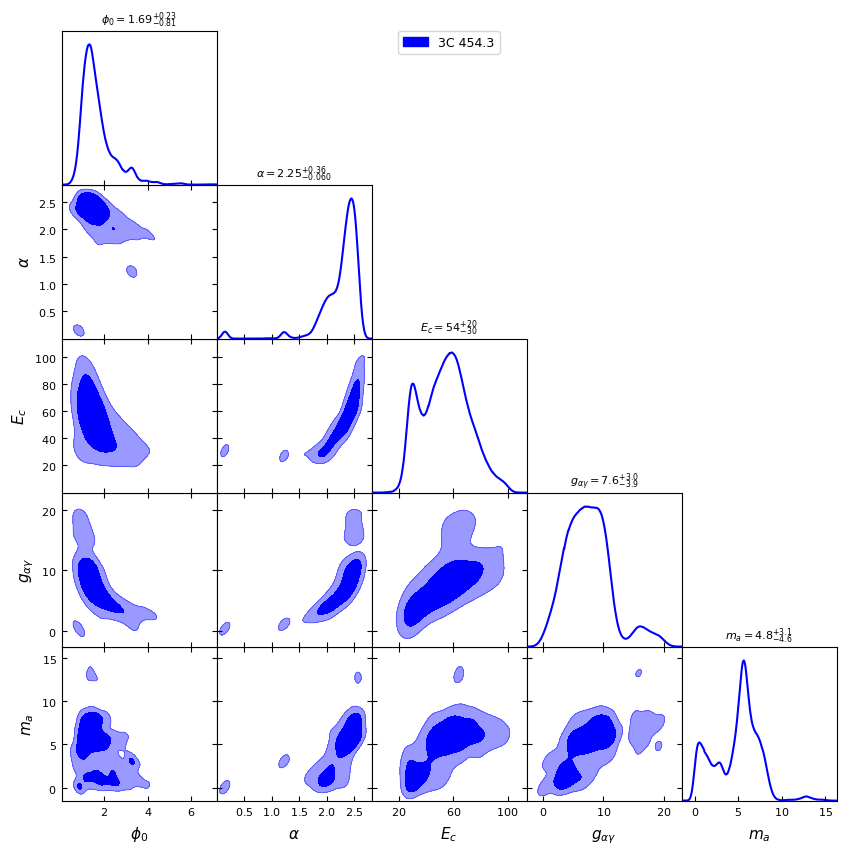

In [315]:
C3454.MCMC([1, 1.9, 30, 2, 0.01])

100%|██████████| 500/500 [00:29<00:00, 17.15it/s]


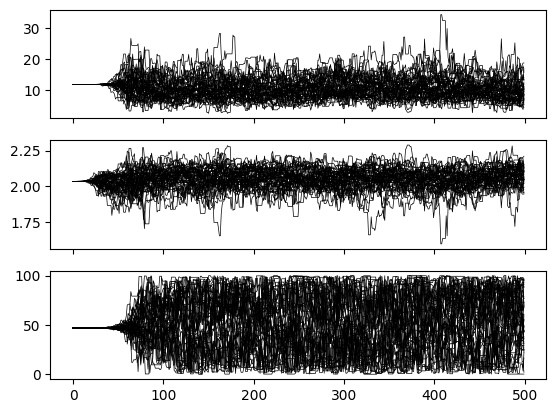

Removed no burn in


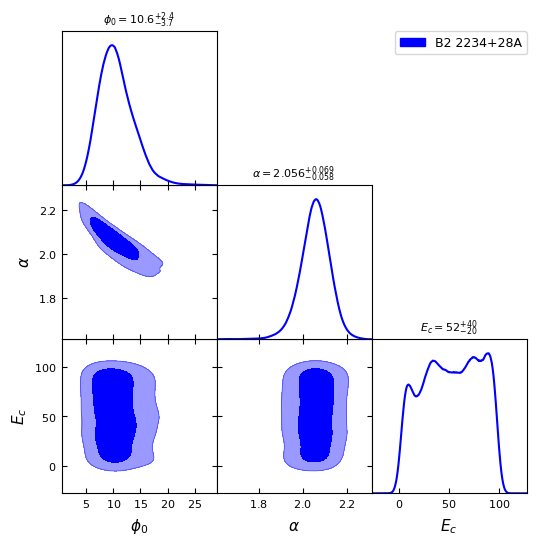

In [299]:
B2A.MCMC([11.9, 2.034, 47])

100%|██████████| 500/500 [00:40<00:00, 12.49it/s]


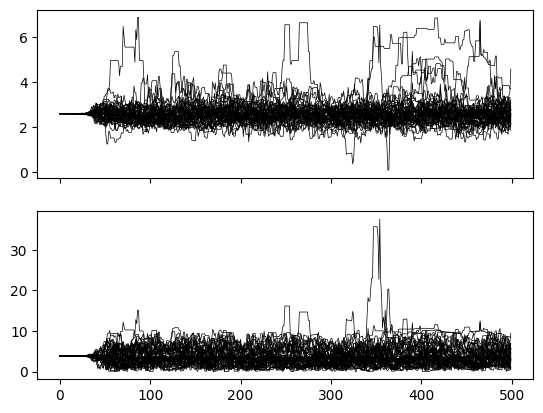

Removed no burn in


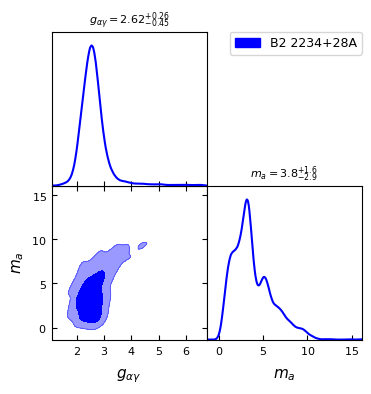

In [300]:
B2A.MCMC([2.6, 3.8], [11.9, 2.034, 47])